In [1]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
print ('-This section done-')

import sys
sys.path.append("/Users/omerorhan/Desktop/UCSC/Deep Learning/DeepLearningUCSC/venv/homework/Assignments/") 


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


-This section done-


In [12]:
#getting data
import weather
weather.maybe_download_and_extract()
cities = weather.cities
print(cities)
#%%time
df = weather.load_resampled_data()
print(df.head())

Data has apparently already been downloaded and unpacked.
['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']
                      Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      N

-This section done-


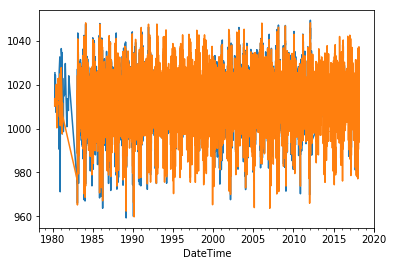

In [27]:
df['Esbjerg']['Pressure'].plot()
df['Roskilde']['Pressure'].plot()
df.values.shape
df.head(1)

df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)
print ('-This section done-')

In [28]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [29]:
# Converting Data Frames to Numpy array::::
x_data = df
print("X_Shape::::")
print(type(x_data))
print("Shape:", x_data.shape)

num_data = len(x_data)
print("# of input data ",num_data)
train_split = 1
num_train = int(train_split * num_data)
print("# of Training data: ",num_train)
x_train = x_data[0:num_train]
num_x_signals = x_data.shape[1]
print(num_x_signals)

X_Shape::::
<class 'pandas.core.frame.DataFrame'>
Shape: (333109, 20)
# of input data  333109
# of Training data:  333109
20


In [30]:
# Scaling data
#The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use scikit-learn for this.
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
#Data Generator
print(x_train_scaled.shape)


Min: 0.0
Max: 1.0000000000000002
[[0.53763441 0.56488035 0.3100304  ... 0.77142857 0.16438356 0.47826087]
 [0.53763441 0.56723964 0.31306991 ... 0.77142857 0.16438356 0.52173913]
 [0.53763441 0.56791372 0.29483283 ... 0.76666667 0.16438356 0.56521739]
 ...
 [0.3781362  0.71991911 0.2674772  ... 0.14285714 0.16164384 0.91304348]
 [0.37992832 0.71789687 0.21884498 ... 0.14285714 0.16164384 0.95652174]
 [0.37275986 0.71385238 0.21884498 ... 0.14285714 0.16164384 1.        ]]


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [34]:
lookback = 2352 # was 1440. 24 hours per day into 14 days = 168*14 = 2352
step = 6 # Original was 6
delay = 144 # We will predict 1 days in future. hence 24*6 = 144
batch_size = 128
#data—The original array of floating-point data
#lookback—How many timesteps back the input data should go.
#delay—How many timesteps in the future the target should be.
#min_index and max_index—Indices in the data array that delimit which time-
#steps to draw from. This is useful for keeping a segment of the data for valida-
#tion and another for testing.
#shuffle—Whether to shuffle the samples or draw them in chronological order.
#batch_size—The number of samples per batch.
#step—The period, in timesteps, at which you sample data. set it to 1 in
#order to draw one data point every hour.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1])) # Size = Batchsize,lookback,20
        targets = np.zeros((len(rows),)) #Size typically Batchsize
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        #print(np.shape(samples))
        #print(np.shape(targets))
        yield samples, targets

        
train_gen = generator(x_train_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=20000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(x_train_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=20001,
                    max_index=30000,
                    step=step,
                    batch_size=batch_size)
val_steps = (30000 - 20001 - lookback)



In [37]:
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x_train_scaled.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') 
history = model.fit_generator(train_gen,
steps_per_epoch=500, epochs=4, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/4


  1/500 [..............................] - ETA: 6:21 - loss: 0.9812

  5/500 [..............................] - ETA: 1:21 - loss: 6.5327

  7/500 [..............................] - ETA: 1:01 - loss: 4.8353

 11/500 [..............................] - ETA: 41s - loss: 3.2849 

 14/500 [..............................] - ETA: 34s - loss: 2.8511

 16/500 [..............................] - ETA: 32s - loss: 2.5643

 17/500 [>.............................] - ETA: 32s - loss: 2.4348

 18/500 [>.............................] - ETA: 32s - loss: 2.4288

 19/500 [>.............................] - ETA: 33s - loss: 2.3060

 20/500 [>.............................] - ETA: 33s - loss: 2.2003

 22/500 [>.............................] - ETA: 32s - loss: 2.0868

 24/500 [>.............................] - ETA: 30s - loss: 1.9808

 26/500 [>.............................] - ETA: 30s - loss: 1.8851

 27/500 [>.............................] - ETA: 30s - loss: 1.8547

 29/500 [>.............................] - ETA: 29s - loss: 1.7715

 31/500 [>.............................] - ETA: 28s - loss: 1.6934

 32/500 [>.............................] - ETA: 28s - loss: 1.6512

 34/500 [=>............................] - ETA: 28s - loss: 1.5889

 36/500 [=>............................] - ETA: 27s - loss: 1.5325

 38/500 [=>............................] - ETA: 27s - loss: 1.4803

 40/500 [=>............................] - ETA: 26s - loss: 1.4340

 41/500 [=>............................] - ETA: 26s - loss: 1.4092

 43/500 [=>............................] - ETA: 25s - loss: 1.3693

 45/500 [=>............................] - ETA: 25s - loss: 1.3278

 46/500 [=>............................] - ETA: 25s - loss: 1.3111

 48/500 [=>............................] - ETA: 25s - loss: 1.2805

 50/500 [==>...........................] - ETA: 24s - loss: 1.2520

 51/500 [==>...........................] - ETA: 24s - loss: 1.2385

 53/500 [==>...........................] - ETA: 24s - loss: 1.2124

KeyboardInterrupt: 

In [35]:
dropout = 0.2
from keras.layers import LSTM
model = Sequential()
# We will be adding LSTM cell from Keras.
#model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lookback// step, x_train_scaled.shape[-1]), stateful=True, dropout=dropout))
#model.add(Dense(1))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit_generator(train_gen,
steps_per_epoch=500, epochs=5, validation_data=val_gen, validation_steps=val_steps)
# make predictions
#trainPredict = model.predict(train_gen, batch_size=batch_size)
#model.reset_states()


Using TensorFlow backend.


TypeError: The added layer must be an instance of class Layer. Found: <keras.layers.recurrent.LSTM object at 0x141f92470>

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(333109, 20)

(333109, 18)

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }

    .dataframe thead tr:last-of-type th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="4" halign="left">Aalborg</th>
      <th colspan="4" halign="left">Aarhus</th>
      <th colspan="4" halign="left">Esbjerg</th>
      <th colspan="4" halign="left">Odense</th>
      <th colspan="4" halign="left">Roskilde</th>
    </tr>
    <tr>
      <th></th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
      <th>Temp</th>
      <th>Pressure</th>
      <th>WindSpeed</th>
      <th>WindDir</th>
    </tr>
    <tr>
      <th>DateTime</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1980-03-01 11:00:00</th>
      <td>5.0</td>
      <td>1007.766667</td>
      <td>10.2</td>
      <td>280.0</td>
      <td>5.0</td>
      <td>1008.3</td>
      <td>15.4</td>
      <td>290.0</td>
      <td>6.083333</td>
      <td>NaN</td>
      <td>12.383333</td>
      <td>310.0</td>
      <td>6.142857</td>
      <td>1011.066667</td>
      <td>12.585714</td>
      <td>290.0</td>
      <td>5.0</td>
      <td>NaN</td>
      <td>11.466667</td>
      <td>280.0</td>
    </tr>
  </tbody>
</table>
</div>

X_Shape::::
<class 'numpy.ndarray'>
Shape: (333085, 20)
Y_Shape::::
<class 'numpy.ndarray'>
Shape: (333085, 3)
# of input data  333085
# of Training data:  299776
# of Test data:  33309
20
3


Min: nan
Max: nan


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(299776, 20)
[[-0.44936436 -0.42001645  1.90969353  0.99510771 -0.44563301 -0.43734634
   4.39823774  1.07168148 -0.34625704  2.77328491  1.22183406 -0.37028186
  -0.24149001  2.76945205  1.11632061 -0.44183742  2.38304315  0.89245276
  -1.1545607  -0.07225043]
 [-0.44936436 -0.40014786  1.94555902  1.10833011 -0.44563301 -0.41087075
   3.62104988  0.95028072 -0.27253896  2.95938096  1.22183406 -0.24726863
  -0.2293943   2.30759351  1.11632061 -0.44183742  2.7439533   0.89245276
  -1.1545607   0.07221188]
 [-0.44936436 -0.39447112  1.73036607  1.10833011 -0.44563301 -0.42557941
   4.39823774  0.95028072 -0.22748902  3.09378367  1.21553133 -0.24726863
  -0.22032252  2.60150349  1.11632061 -0.4185853   2.98456006  0.87311934
  -1.1545607   0.21667419]
 [-0.54429809 -0.38879438  2.23248296  1.03284851 -0.44563301 -0.44028807
   4.20394077  1.19308224 -0.32577979  2.96971963  1.17771496 -0.26777083
  -0.21125073  2.82590143  1.11632061 -0.32557684  2.6838016   0.77645227
  -1.1545607   0.3

(299776, 20)
(299776, 3)


(33309, 20)


Epoch 1/5
499/500 [============================>.] - ETA: 0s - loss: 0.0360

KeyboardInterrupt: ignored